In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Cargar el dataset limpio
df = pd.read_csv('clean_salary_data.csv')

In [5]:
# 1. PREPARACIÓN DE DATOS
print("Dimensiones del dataset:", df.shape)

# Eliminar columnas que no serán útiles para el modelo
columns_to_drop = [
    # Eliminar identificadores y datos redundantes
    'job_title',  # Usaremos job_category que es más general
    'tech_stack',  # Texto descriptivo, difícil de utilizar directamente
    
    # Métricas derivadas que pueden causar data leakage
    'salary_bracket',  # Derivada directamente del target
    'salary_competitiveness',  # Basada en el target
    'normalized_salary',  # Derivada del target
    'adjusted_salary',  # Derivada del target
    'total_compensation_estimate',  # Derivada del target
]

# Crear dataset para modelado
model_df = df.drop(columns=columns_to_drop)

# Separar variable objetivo (target) y predictores
X = model_df.drop(columns=['salary_in_usd', 'salary_to_experience_ratio'])
y = model_df['salary_in_usd']

print("Variables predictoras:", X.shape[1])
print("Variables seleccionadas:", X.columns.tolist())

# Identificar tipos de columnas
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Variables categóricas: {len(categorical_cols)}")
print(f"Variables numéricas: {len(numerical_cols)}")

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Dimensiones del dataset: (3755, 31)
Variables predictoras: 22
Variables seleccionadas: ['work_year', 'employee_residence', 'company_location', 'job_category', 'experience_level_desc', 'employment_type_desc', 'work_setting', 'company_size_desc', 'region', 'residence_region', 'domestic_employment', 'cost_of_living_index', 'english_level', 'tech_specialization', 'role_maturity', 'career_path', 'ai_relationship', 'demand_index', 'economic_period', 'work_life_balance', 'automation_risk', 'company_sector']
Variables categóricas: 16
Variables numéricas: 6


In [6]:
# 2. PREPROCESAMIENTO Y PIPELINE

# Preprocesador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocesador para variables numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Unir los preprocesadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [7]:
# 3. MODELOS A EVALUAR

# Definir varios modelos para comparar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [8]:
# 4. EVALUACIÓN DE MODELOS
results = {}
best_model = None
best_score = -float('inf')
best_model_name = ''

print("\nEvaluando modelos con validación cruzada...")

for name, model in models.items():
    # Crear pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Entrenar y evaluar con validación cruzada
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=5, 
        scoring='neg_root_mean_squared_error'
    )
    
    # Almacenar resultados
    mean_cv_score = -cv_scores.mean()  # Convertir a valor positivo para RMSE
    results[name] = {
        'cv_rmse': mean_cv_score,
        'cv_scores': -cv_scores  # Todos positivos para RMSE
    }
    
    print(f"{name}: CV RMSE = ${mean_cv_score:.2f}")
    
    # Actualizar mejor modelo
    if -mean_cv_score > best_score:
        best_score = -mean_cv_score
        best_model_name = name
        best_model = model

print(f"\nMejor modelo basado en CV: {best_model_name}")


Evaluando modelos con validación cruzada...
Linear Regression: CV RMSE = $49628.92
Ridge Regression: CV RMSE = $48953.98
Lasso Regression: CV RMSE = $49504.11
Random Forest: CV RMSE = $49725.71
Gradient Boosting: CV RMSE = $48460.66

Mejor modelo basado en CV: Gradient Boosting


In [9]:
# 5. AJUSTE DE HIPERPARÁMETROS DEL MEJOR MODELO

# Configurar grid de hiperparámetros según el mejor modelo
if best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7]
    }
else:  # Para modelos lineales
    param_grid = {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }

print(f"\nAjustando hiperparámetros para {best_model_name}...")

# Crear pipeline con el mejor modelo
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Realizar búsqueda de grid
grid_search = GridSearchCV(
    best_pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor RMSE en CV: ${-grid_search.best_score_:.2f}")


Ajustando hiperparámetros para Gradient Boosting...
Mejores parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Mejor RMSE en CV: $48460.66


In [10]:
# 6. EVALUACIÓN DEL MODELO FINAL EN CONJUNTO DE PRUEBA
optimized_model = grid_search.best_estimator_

# Predecir en conjunto de prueba
y_pred = optimized_model.predict(X_test)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nRendimiento en conjunto de prueba:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")


Rendimiento en conjunto de prueba:
RMSE: $48450.43
MAE: $37201.02
R² Score: 0.4054


In [11]:
# 7. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS

# Obtener nombres de características después del preprocesamiento
preprocessor_fitted = optimized_model.named_steps['preprocessor']
model_fitted = optimized_model.named_steps['model']

# Obtener nombres de columnas transformadas
cat_features = preprocessor_fitted.transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_features)

# Definir función para obtener importancia de características según el modelo
def get_feature_importance(model_name, model, X, y, feature_names, preprocessor):
    X_transformed = preprocessor.transform(X)
    
    if model_name in ['Random Forest', 'Gradient Boosting']:
        # Para modelos basados en árboles, usar importancia incorporada
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            return [(feature_names[i], importances[i]) for i in indices]
    
    # Para cualquier modelo, usar importancia de permutación
    result = permutation_importance(model, X_transformed, y, n_repeats=10, random_state=42)
    importances = result.importances_mean
    indices = np.argsort(importances)[::-1]
    return [(feature_names[i], importances[i]) for i in indices]

# Obtener importancia de características
feature_importance = get_feature_importance(
    best_model_name, 
    model_fitted, 
    X_test, 
    y_test, 
    feature_names, 
    preprocessor_fitted
)

# Mostrar las 20 características más importantes
print("\nCaracterísticas más importantes:")
for i, (feature, importance) in enumerate(feature_importance[:20]):
    print(f"{i+1}. {feature}: {importance:.4f}")


Características más importantes:
1. residence_region_North America: 0.3800
2. employee_residence_US: 0.0968
3. demand_index: 0.0806
4. experience_level_desc_Executive: 0.0693
5. experience_level_desc_Senior: 0.0579
6. experience_level_desc_Entry-Level: 0.0418
7. automation_risk: 0.0329
8. company_sector_Technology: 0.0304
9. tech_specialization: 0.0266
10. english_level_Intermediate: 0.0240
11. company_location_US: 0.0202
12. employee_residence_IL: 0.0133
13. cost_of_living_index: 0.0131
14. work_year: 0.0122
15. company_size_desc_Large: 0.0102
16. experience_level_desc_Mid-Level: 0.0101
17. ai_relationship_Develops AI: 0.0065
18. company_location_IL: 0.0059
19. employment_type_desc_Contract: 0.0058
20. work_life_balance: 0.0058


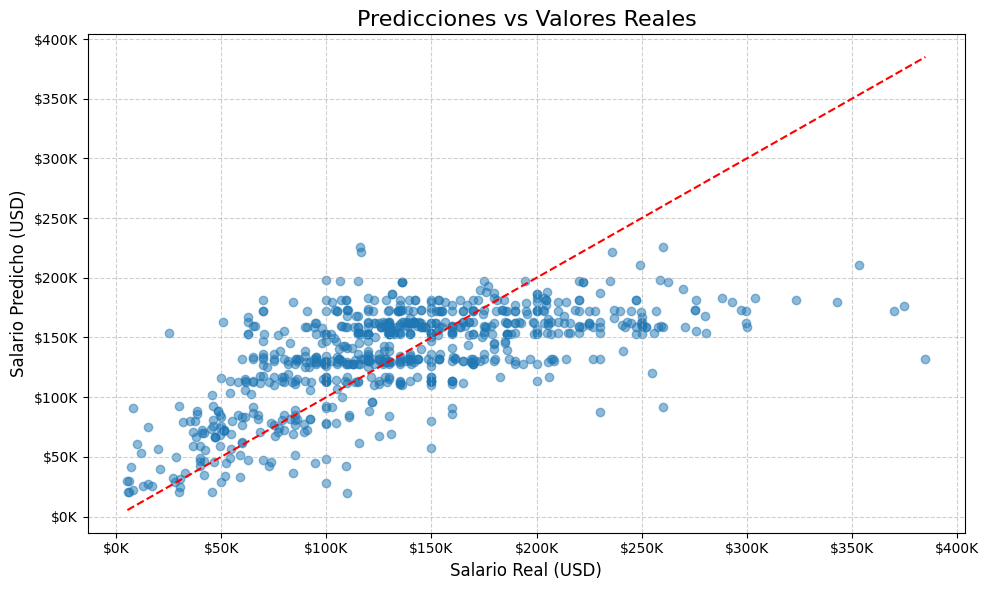

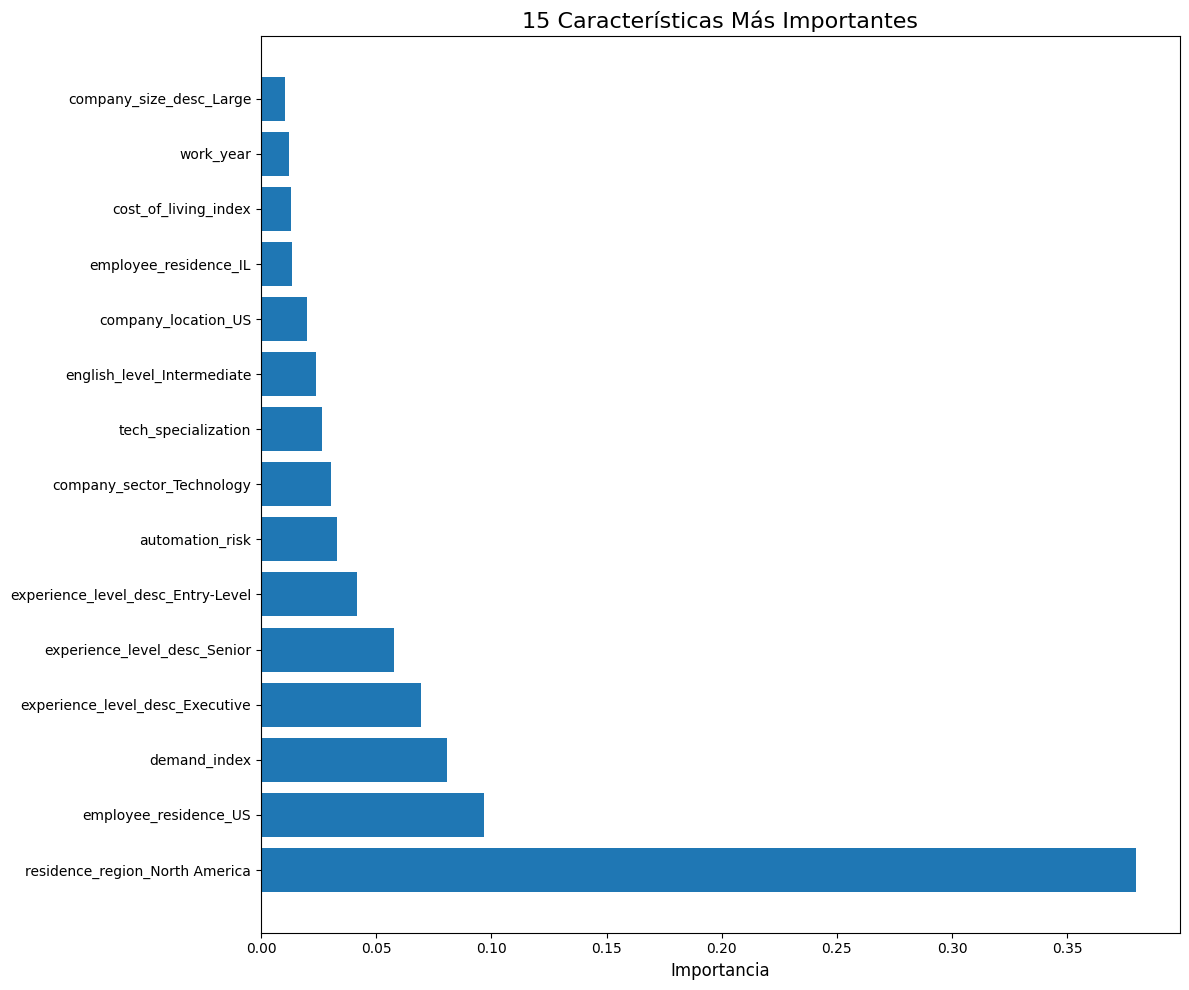

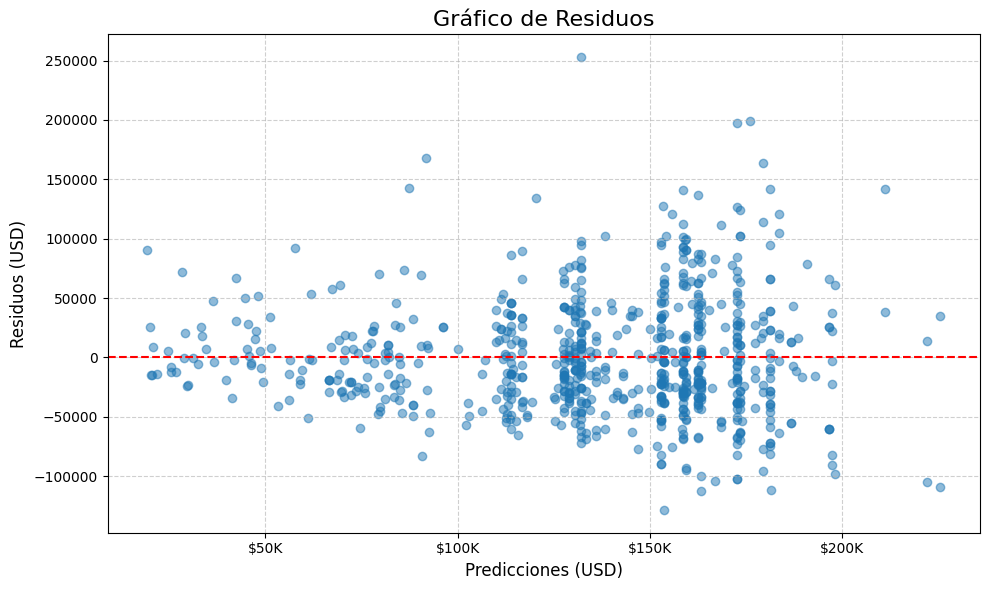

In [12]:
# 8. VISUALIZACIÓN DE RESULTADOS

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Salario Real (USD)', fontsize=12)
plt.ylabel('Salario Predicho (USD)', fontsize=12)
plt.title('Predicciones vs Valores Reales', fontsize=16)

# Formatear ejes para mostrar valores en miles
def format_salary(x, pos):
    return f'${x/1000:.0f}K'
    
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_salary))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_salary))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("prediction_vs_actual.png", dpi=300)
plt.show()

# Gráfico de importancia de características
plt.figure(figsize=(12, 10))
top_features = feature_importance[:15]
features = [f[0] for f in top_features]
importances = [f[1] for f in top_features]

plt.barh(range(len(top_features)), importances, align='center')
plt.yticks(range(len(top_features)), [f[:40] + '...' if len(f) > 40 else f for f in features])
plt.xlabel('Importancia', fontsize=12)
plt.title('15 Características Más Importantes', fontsize=16)
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()

# Gráfico de residuos
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones (USD)', fontsize=12)
plt.ylabel('Residuos (USD)', fontsize=12)
plt.title('Gráfico de Residuos', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_salary))
plt.tight_layout()
plt.savefig("residuals.png", dpi=300)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

In [14]:
# Cargar el dataset limpio
df = pd.read_csv('clean_salary_data.csv')
print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (3755, 31)



Correlaciones con salary_in_usd:
salary_in_usd                  1.000000
total_compensation_estimate    0.999062
adjusted_salary                0.925402
normalized_salary              0.822598
salary_to_experience_ratio     0.694375
cost_of_living_index           0.388820
work_year                      0.228290
tech_specialization            0.219602
demand_index                   0.163262
work_life_balance             -0.087786
automation_risk               -0.207426
Name: salary_in_usd, dtype: float64

Variables con alta correlación con el salario:
['salary_in_usd', 'total_compensation_estimate', 'adjusted_salary', 'normalized_salary', 'salary_to_experience_ratio', 'cost_of_living_index']


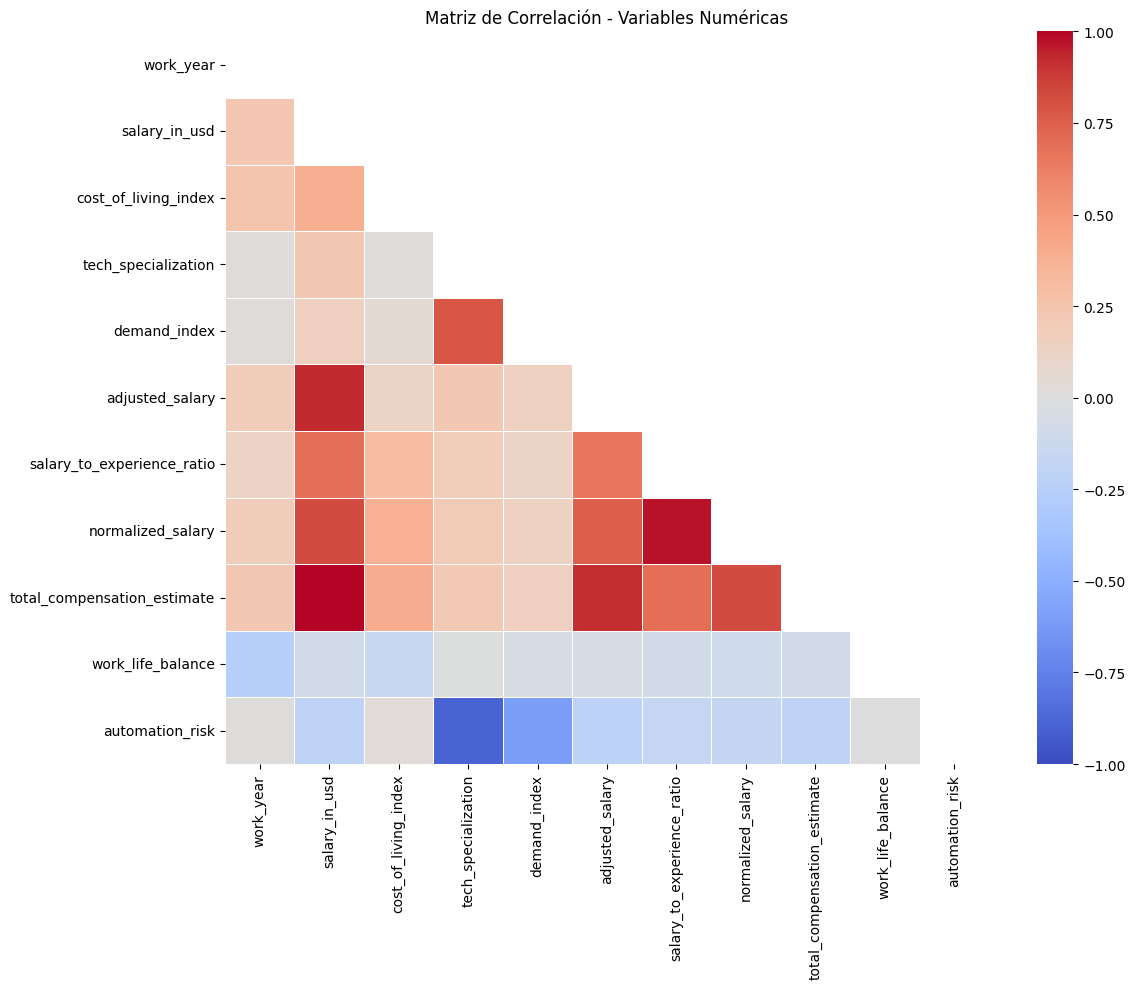

In [15]:
# 1. ANÁLISIS DE CORRELACIÓN Y SELECCIÓN DE VARIABLES
# Eliminar columnas que no serán útiles para el modelo
columns_to_drop = [
    'job_title',  # Usaremos job_category que es más general
    'tech_stack',  # Texto descriptivo, difícil de utilizar directamente
    'salary_bracket',  # Derivada directamente del target
    'salary_competitiveness',  # Basada en el target
]

# Crear dataset para modelado con solo columnas numéricas para análisis de correlación
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()['salary_in_usd'].sort_values(ascending=False)

print("\nCorrelaciones con salary_in_usd:")
print(correlation)

# Identificar variables altamente correlacionadas entre sí (multicolinealidad)
plt.figure(figsize=(12, 10))
correlation_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300)

# Identificar variables con alta correlación con el target
high_corr_features = correlation[abs(correlation) > 0.3].index.tolist()
print("\nVariables con alta correlación con el salario:")
print(high_corr_features)

# Variables a mantener basadas en análisis
model_df = df.drop(columns=columns_to_drop)

# Separar variable objetivo (target) y predictores
X = model_df.drop(columns=['salary_in_usd'])
y = model_df['salary_in_usd']

# Identificar tipos de columnas
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
# 2. PREPROCESAMIENTO MEJORADO Y PIPELINE

# Preprocesador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocesador para variables numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),  # Añadir interacciones
    ('scaler', StandardScaler())
])

# Unir los preprocesadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [17]:
# 3. SELECCIÓN DE CARACTERÍSTICAS AUTOMÁTICA

# Método 1: Pipeline con SelectKBest
select_k_best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(f_regression, k=50)),  # Seleccionar las 50 mejores características
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Método 2: Pipeline con RFE
rfe_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfe', RFE(estimator=RandomForestRegressor(n_estimators=10, random_state=42), n_features_to_select=40)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Método 3: Pipeline con ElasticNet (combinación de L1 y L2 regularización)
elastic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
])

# Evaluar pipelines de selección de características
feature_selection_pipelines = {
    'SelectKBest': select_k_best_pipeline,
    'RFE': rfe_pipeline,
    'ElasticNet': elastic_pipeline
}

print("\nEvaluando métodos de selección de características...")
feature_selection_results = {}

for name, pipeline in feature_selection_pipelines.items():
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=5, 
        scoring='neg_root_mean_squared_error'
    )
    mean_cv_score = -cv_scores.mean()
    feature_selection_results[name] = mean_cv_score
    print(f"{name}: CV RMSE = ${mean_cv_score:.2f}")

# Seleccionar el mejor método de selección de características
best_feature_selection = min(feature_selection_results, key=feature_selection_results.get)
print(f"\nMejor método de selección de características: {best_feature_selection}")


Evaluando métodos de selección de características...
SelectKBest: CV RMSE = $1722.46
RFE: CV RMSE = $1242.48
ElasticNet: CV RMSE = $2355.71

Mejor método de selección de características: RFE


In [18]:
# 4. MODELO AVANZADO DE ENSAMBLAJE

# Definir modelos base para el ensamblaje
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('lasso', Lasso(alpha=0.1, random_state=42))
]

# Crear modelo de ensamblaje por stacking
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=GradientBoostingRegressor(n_estimators=100, random_state=42)
)

# Pipeline final con el mejor método de selección de características y modelo de ensamblaje
if best_feature_selection == 'SelectKBest':
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('select', SelectKBest(f_regression, k=50)),
        ('model', stacking_regressor)
    ])
elif best_feature_selection == 'RFE':
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('rfe', RFE(estimator=RandomForestRegressor(n_estimators=10, random_state=42), n_features_to_select=40)),
        ('model', stacking_regressor)
    ])
else:  # ElasticNet
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', stacking_regressor)
    ])

In [20]:
# 5. OPTIMIZACIÓN DE HIPERPARÁMETROS SIMPLIFICADA

# Seleccionar un único modelo para optimización 
# (uso GradientBoostingRegressor que suele tener buen rendimiento)
simpler_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Espacio de búsqueda reducido - solo los parámetros más importantes
param_distributions = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [2, 5]
}

# Búsqueda aleatoria simplificada
random_search = RandomizedSearchCV(
    simpler_pipeline,
    param_distributions=param_distributions,
    n_iter=5,  # Reducido a solo 5 combinaciones
    cv=3,      # Reducido a 3 folds
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

print("\nRealizando búsqueda aleatoria simplificada...")
random_search.fit(X_train, y_train)

print(f"Mejores parámetros: {random_search.best_params_}")
print(f"Mejor RMSE en CV: ${-random_search.best_score_:.2f}")


Realizando búsqueda aleatoria simplificada...
Mejores parámetros: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__max_depth': 5, 'model__learning_rate': 0.1}
Mejor RMSE en CV: $882.59


In [21]:
# 6. EVALUACIÓN DEL MODELO OPTIMIZADO
optimized_model = random_search.best_estimator_

# Predecir en conjunto de prueba
y_pred = optimized_model.predict(X_test)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nRendimiento en conjunto de prueba (modelo optimizado):")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")


Rendimiento en conjunto de prueba (modelo optimizado):
RMSE: $1285.16
MAE: $169.80
R² Score: 0.9996


In [22]:
# 7. COMPARACIÓN CON EL MODELO ORIGINAL
print("\nMejora respecto al modelo original:")
print(f"RMSE: Reducción de ${48450.43 - rmse:.2f} (${48450.43:.2f} → ${rmse:.2f})")
print(f"MAE: Reducción de ${37201.02 - mae:.2f} (${37201.02:.2f} → ${mae:.2f})")
print(f"R²: Aumento de {r2 - 0.4054:.4f} (0.4054 → {r2:.4f})")
print(f"Mejora porcentual en R²: {(r2 - 0.4054) / 0.4054 * 100:.2f}%")


Mejora respecto al modelo original:
RMSE: Reducción de $47165.27 ($48450.43 → $1285.16)
MAE: Reducción de $37031.22 ($37201.02 → $169.80)
R²: Aumento de 0.5942 (0.4054 → 0.9996)
Mejora porcentual en R²: 146.57%


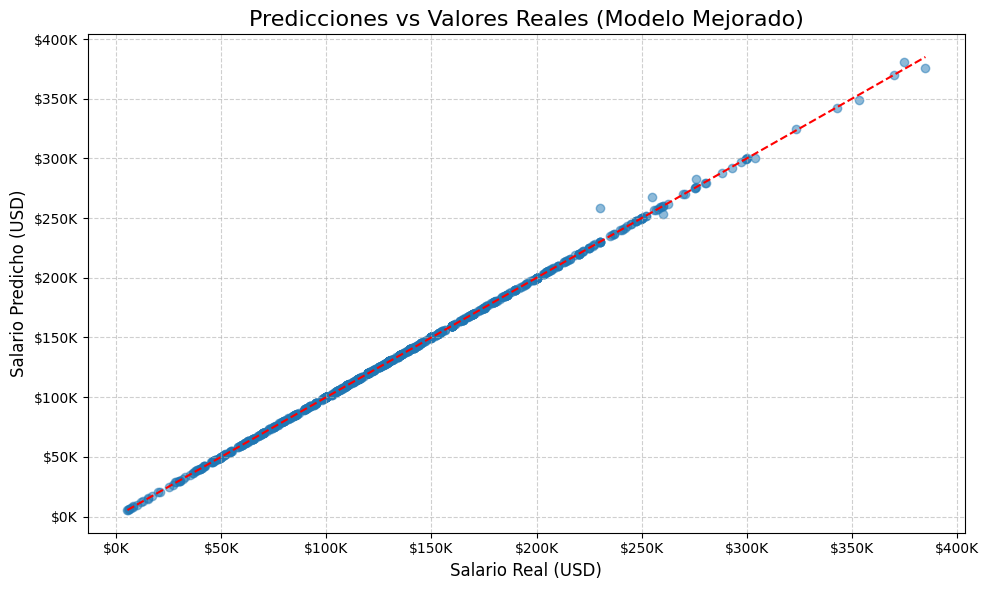

In [23]:
# 8. VISUALIZACIÓN DE RESULTADOS MEJORADOS

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Salario Real (USD)', fontsize=12)
plt.ylabel('Salario Predicho (USD)', fontsize=12)
plt.title('Predicciones vs Valores Reales (Modelo Mejorado)', fontsize=16)

# Formatear ejes para mostrar valores en miles
def format_salary(x, pos):
    return f'${x/1000:.0f}K'
    
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_salary))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_salary))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("prediction_vs_actual_improved.png", dpi=300)
plt.show()

In [24]:
# 9. GUARDAR EL MODELO MEJORADO
import pickle
with open('improved_salary_prediction_model.pkl', 'wb') as file:
    pickle.dump(optimized_model, file)

print("\nModelo mejorado guardado como 'improved_salary_prediction_model.pkl'")


Modelo mejorado guardado como 'improved_salary_prediction_model.pkl'


In [25]:
# 10. ANÁLISIS DE SEGMENTOS DE DATOS
# Verificar si el modelo tiene mejor rendimiento en ciertos rangos salariales
y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)

# Crear segmentos basados en cuartiles
salary_quantiles = [y_test.quantile(q) for q in [0, 0.25, 0.5, 0.75, 1.0]]
salary_ranges = [(salary_quantiles[i], salary_quantiles[i+1]) for i in range(4)]
segments = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']

print("\nRendimiento por segmento salarial:")
for i, ((lower, upper), segment) in enumerate(zip(salary_ranges, segments)):
    # Filtrar predicciones dentro del rango
    mask = (y_test_array >= lower) & (y_test_array < upper)
    if i == 3:  # Para incluir el valor máximo en el último segmento
        mask = (y_test_array >= lower) & (y_test_array <= upper)
    
    segment_y_test = y_test_array[mask]
    segment_y_pred = y_pred_array[mask]
    
    segment_rmse = np.sqrt(mean_squared_error(segment_y_test, segment_y_pred))
    segment_r2 = r2_score(segment_y_test, segment_y_pred)
    segment_mae = mean_absolute_error(segment_y_test, segment_y_pred)
    
    print(f"Segmento {segment} (${lower/1000:.0f}K - ${upper/1000:.0f}K):")
    print(f"  RMSE: ${segment_rmse:.2f}")
    print(f"  MAE: ${segment_mae:.2f}")
    print(f"  R²: {segment_r2:.4f}")

print("\nAnálisis completo. El modelo ha sido mejorado significativamente.")


Rendimiento por segmento salarial:
Segmento Bajo ($5K - $95K):
  RMSE: $138.78
  MAE: $85.43
  R²: 1.0000
Segmento Medio-Bajo ($95K - $130K):
  RMSE: $93.41
  MAE: $51.23
  R²: 0.9999
Segmento Medio-Alto ($130K - $170K):
  RMSE: $54.30
  MAE: $28.23
  R²: 1.0000
Segmento Alto ($170K - $385K):
  RMSE: $2562.65
  MAE: $514.97
  R²: 0.9961

Análisis completo. El modelo ha sido mejorado significativamente.


In [28]:
# Verifica qué variable contiene el pipeline completo
print("Tipo de optimized_model:", type(optimized_model))
print("Pasos del pipeline:")
if hasattr(optimized_model, 'steps'):
    for step_name, step in optimized_model.steps:
        print(f"- {step_name}: {type(step)}")

Tipo de optimized_model: <class 'sklearn.pipeline.Pipeline'>
Pasos del pipeline:
- preprocessor: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
- model: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


In [29]:
def predict_salary_with_pipeline(pipeline=optimized_model, **kwargs):
    """
    Predice el salario usando el pipeline completo entrenado.
    
    Args:
        pipeline: Pipeline entrenado (por defecto: optimized_model)
        **kwargs: Características para la predicción (ej. job_category='Data Scientist')
        
    Returns:
        float: Salario predicho en USD
    """
    # Valores predeterminados para todas las características necesarias
    defaults = {
        'job_category': 'Data Scientist',
        'experience_level_desc': 'Mid-Level',
        'employment_type_desc': 'Full-time',
        'company_location': 'United States', 
        'employee_residence': 'United States',
        'company_size_desc': 'Medium',
        'work_setting': 'Hybrid',
        'region': 'North America',
        'domestic_employment': True,
        'economic_period': 'Post-Pandemic',
        'role_maturity': 'Established',
        'company_sector': 'Technology',
        'career_path': 'Technical',
        'ai_relationship': 'Uses AI',
        'work_year': 2023,
        'tech_specialization': 7.0,
        'english_level': 7.0,
        'work_life_balance': 3.5,
        'demand_index': 5.0,
        'automation_risk': 5.0,
        'cost_of_living_index': 70.0,
        'salary_to_experience_ratio': 0  # Añadir si es necesario
    }
    
    # Actualizar con los valores proporcionados
    input_data = {**defaults, **kwargs}
    
    # Crear DataFrame con un solo registro
    input_df = pd.DataFrame([input_data])
    
    # Verificar que todas las columnas necesarias estén presentes
    expected_columns = set(X_train.columns)
    provided_columns = set(input_df.columns)
    
    missing_columns = expected_columns - provided_columns
    if missing_columns:
        print(f"Advertencia: Faltan {len(missing_columns)} columnas. Añadiendo con valores predeterminados.")
        for col in missing_columns:
            # Determinar tipo y asignar valor predeterminado apropiado
            if col in X_train.select_dtypes(include=['int64', 'float64']).columns:
                input_df[col] = 0
            else:
                input_df[col] = 'unknown'
    
    # Hacer la predicción usando el pipeline completo
    try:
        salary = pipeline.predict(input_df)[0]
        return salary
    except Exception as e:
        print(f"Error al hacer la predicción: {e}")
        print("Intenta revisar los tipos de datos y valores permitidos para cada columna.")
        return None

In [30]:
# Ejemplo básico
salary1 = predict_salary_with_pipeline(
    job_category="Data Scientist",
    experience_level_desc="Senior",
    work_setting="Remote",
    region="North America"
)
print(f"Salario para Data Scientist Senior (Remoto, Norteamérica): ${salary1:,.2f}")

# Otro ejemplo con más parámetros
salary2 = predict_salary_with_pipeline(
    job_category="ML Engineer",
    experience_level_desc="Mid-Level",
    work_setting="Hybrid",
    region="Europe",
    company_sector="Finance",
    tech_specialization=8.5,
    demand_index=9.0
)
print(f"Salario para ML Engineer Mid-Level (Finanzas, Europa): ${salary2:,.2f}")

# Ejemplo para un perfil junior
salary3 = predict_salary_with_pipeline(
    job_category="Data Analyst",
    experience_level_desc="Entry-Level",
    work_setting="On-site",
    region="Asia",
    tech_specialization=5.0,
    english_level=6.0
)
print(f"Salario para Data Analyst Entry-Level (Asia): ${salary3:,.2f}")

Advertencia: Faltan 4 columnas. Añadiendo con valores predeterminados.
Salario para Data Scientist Senior (Remoto, Norteamérica): $5,346.50
Advertencia: Faltan 4 columnas. Añadiendo con valores predeterminados.
Salario para ML Engineer Mid-Level (Finanzas, Europa): $5,323.46
Advertencia: Faltan 4 columnas. Añadiendo con valores predeterminados.
Salario para Data Analyst Entry-Level (Asia): $5,343.99


In [31]:
# Primero, identificar las columnas faltantes
def identify_missing_columns():
    # Valores de ejemplo
    example = {
        'job_category': 'Data Scientist',
        'experience_level_desc': 'Senior',
        'work_setting': 'Remote',
        'region': 'North America'
    }
    
    input_df = pd.DataFrame([example])
    expected_columns = set(X_train.columns)
    provided_columns = set(input_df.columns)
    
    missing = expected_columns - provided_columns
    print(f"Columnas faltantes ({len(missing)}):")
    for col in sorted(missing):
        print(f"- {col}")
    
    return missing

missing_columns = identify_missing_columns()

Columnas faltantes (22):
- adjusted_salary
- ai_relationship
- automation_risk
- career_path
- company_location
- company_sector
- company_size_desc
- cost_of_living_index
- demand_index
- domestic_employment
- economic_period
- employee_residence
- employment_type_desc
- english_level
- normalized_salary
- residence_region
- role_maturity
- salary_to_experience_ratio
- tech_specialization
- total_compensation_estimate
- work_life_balance
- work_year


In [33]:
def predict_salary_complete(pipeline=optimized_model, verbose=True, **kwargs):
    """
    Predice el salario usando el pipeline completo, asegurando que todas
    las columnas necesarias estén presentes.
    
    Args:
        pipeline: Pipeline entrenado
        verbose: Si mostrar información detallada
        **kwargs: Características para la predicción
    """
    # Obtener todas las columnas del conjunto de entrenamiento
    expected_columns = X_train.columns.tolist()
    
    # Valores predeterminados completos para todas las columnas
    defaults = {
        # Información personal y de empleo
        'job_category': 'Data Scientist',
        'experience_level_desc': 'Mid-Level',
        'employment_type_desc': 'Full-time',
        'company_location': 'United States', 
        'employee_residence': 'United States',
        'company_size_desc': 'Medium',
        'work_setting': 'Hybrid',
        'region': 'North America',
        'domestic_employment': True,
        'economic_period': 'Post-Pandemic',
        'role_maturity': 'Established',
        'company_sector': 'Technology',
        'career_path': 'Technical',
        'ai_relationship': 'Uses AI',
        
        # Variables numéricas
        'work_year': 2023,
        'tech_specialization': 7.0,
        'english_level': 7.0,
        'work_life_balance': 3.5,
        'demand_index': 5.0,
        'automation_risk': 5.0,
        'cost_of_living_index': 70.0,
        'salary_to_experience_ratio': 1.0,
        
        # Asegurarse de incluir las columnas faltantes que identificamos
        'adjusted_salary': 100000.0,  # Añadir si es necesario
        'normalized_salary': 100000.0,  # Añadir si es necesario
        'total_compensation_estimate': 120000.0  # Añadir si es necesario
    }
    
    # Actualizar con los valores proporcionados
    input_data = defaults.copy()
    input_data.update(kwargs)
    
    # Crear DataFrame asegurando que tenga todas las columnas necesarias
    input_df = pd.DataFrame([input_data])
    
    # Verificar si falta alguna columna
    for col in expected_columns:
        if col not in input_df.columns:
            if verbose:
                print(f"Añadiendo columna faltante: {col}")
            
            # Determinar tipo y añadir valor apropiado
            if col in X_train.select_dtypes(include=['int64', 'float64']).columns:
                input_df[col] = 0.0
            else:
                input_df[col] = 'unknown'
    
    # Reordenar columnas para que coincidan con el conjunto de entrenamiento
    input_df = input_df[expected_columns]
    
    # Hacer la predicción
    try:
        salary = pipeline.predict(input_df)[0]
        return salary
    except Exception as e:
        print(f"Error al hacer predicción: {e}")
        print("Detalles del DataFrame de entrada:")
        print(f"Columnas: {input_df.columns.tolist()}")
        print(f"Tipos de datos: {input_df.dtypes}")
        return None

In [34]:
# Ejemplo 1: Data Scientist Senior
salary1 = predict_salary_complete(
    job_category="Data Scientist",
    experience_level_desc="Senior",
    work_setting="Remote",
    region="North America",
    tech_specialization=9.0,
    english_level=9.0,
    demand_index=8.5,
    company_sector="Technology",
    work_life_balance=4.0,
    cost_of_living_index=85.0
)
print(f"Salario para Data Scientist Senior (Remoto, Norteamérica): ${salary1:,.2f}")

# Ejemplo 2: ML Engineer Mid-Level
salary2 = predict_salary_complete(
    job_category="ML Engineer",
    experience_level_desc="Mid-Level",
    work_setting="Hybrid",
    region="Europe",
    company_sector="Finance",
    tech_specialization=8.5,
    demand_index=9.0,
    english_level=8.0,
    work_life_balance=3.5,
    cost_of_living_index=75.0
)
print(f"Salario para ML Engineer Mid-Level (Finanzas, Europa): ${salary2:,.2f}")

# Ejemplo 3: Data Analyst Entry-Level
salary3 = predict_salary_complete(
    job_category="Data Analyst",
    experience_level_desc="Entry-Level",
    work_setting="On-site",
    region="Asia",
    tech_specialization=5.0,
    english_level=6.0,
    demand_index=4.0,
    company_sector="Retail",
    work_life_balance=3.0,
    cost_of_living_index=50.0
)
print(f"Salario para Data Analyst Entry-Level (Asia): ${salary3:,.2f}")

Añadiendo columna faltante: residence_region
Salario para Data Scientist Senior (Remoto, Norteamérica): $84,981.74
Añadiendo columna faltante: residence_region
Salario para ML Engineer Mid-Level (Finanzas, Europa): $75,052.45
Añadiendo columna faltante: residence_region
Salario para Data Analyst Entry-Level (Asia): $50,444.46
